In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Kalman Filters

Kalman Filter is a powerfull tool to reconcile the measure of a sensor with the estimation of the value.

Sensors are noise therefore if we can add information to the measure is posible to reduce the noise and get better accurasy, i kind of information we can add is the estimation base on time, by modeling our probleme to take the last measure value and estimate the next, it is posible to use Kalman Filter to add the information of the estimation model with the measure value.

For mor information:
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

## GPS Kalman Filter

This notebook implement Kalman filter to the GPS position of a monolic

This is the easies case, were the model of estimation is the measure do not change.

## Adquiring data

In [2]:
%%writefile iono_models.py
# -*- coding: utf-8 -*-

def get_sat_elv_az(svs, rx):
    """
    http://www.naic.edu/aisr/GPSTEC/drewstuff/MATLAB/elavazim.m
    https://goo.gl/2Kt8Pf
    # https://sourceforge.isae.fr/projects/building-blocks-for-a-leo-ground-station/wiki/Distance_Elevation_and_Azimuth_Calculation
    """
    svs_enu = ecef2enu(svs[:,0], svs[:,1], svs[:,2], rx)
    east, north, up  = svs_enu[0], svs_enu[1], svs_enu[2]

    elevation = up/np.linalg.norm(svs_enu, axis=0)
    azimuth = np.arctan2(east,north)#radians
    idx = np.where(azimuth<0)
    azimuth[idx] += 2*np.pi;
    return elevation, azimuth # radians

def Klobuchar(A,E,time, rx_pos, alphas, betas):
        ####klobuchar  model

        lat, lon, alt = ecef2lla(X=rx_pos[0], Y=rx_pos[1], Z=rx_pos[2])
        C = gpstk.C_MPS #2.99792458e8

        ######bla bla
        phi=(0.0137/(E-0.11))-0.022
        psi=lat+phi*np.cos(A)#2
        if psi > 0.416:
            psi=psi+0.416
        elif psi < -0.416:
            psi=psi-0.416

        lampda=lon+(phi*np.sin(A))/np.cos(psi)#3
        phi_m=lampda+0.064*np.cos(psi-1.617)#4
        t=43200*lampda+time#.getSecondOfDay()#5
        if t > 86400:
            t=t-86400
        elif t < 0:
            t=t+86400
        ##basados en el modelo expuesto en el link, se cambian el exponente de la sumatoria.
        ##http://what-when-how.com/gps/ionospheric-effects-physical-influences-of-gps-surveying-part-2/
        A_I=alphas[0]+alphas[1]*phi_m+alphas[2]*phi_m**2+alphas[3]*phi_m**3 #6
        if A_I < 0:
            A_I=0

        P_I=betas[0]+betas[1]*phi_m+betas[2]*phi_m**2+betas[3]*phi_m**3 #7
        if P_I < 72000:
            P_I=72000

        X_I=2*np.pi*(t-50400)/P_I #8
        F=1+16*(0.53-E)**3#9

        if np.fabs(X_I) > 1.57:#10
            IL1_GPS=((5e-9)+A_I*(1-(((X_I)**2)/2)+((X_I)**4)/24))*F*C
        elif np.fabs(X_I) < 1.57:
            IL1_GPS=(5e-9)*F*C
        else :
            IL1_GPS=(5e-9)*F*C
        return IL1_GPS#/F
    
    
    
def get_ionodelay(rx_pos, gps_time, dat, 
                  codigo="C1", 
                  apply_iono_model="", apply_earth_rotation=True):
    
    c = gpstk.C_MPS #299792458
    R_earth = 6367444.657  # 6,371 km
    h_iono  = 400e3
    
    svs = np.array(dat["prns_pos"], dtype=pd.Series)[0]
    prs = np.array(dat[codigo], dtype=pd.Series)[0]
    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(svs, prs)
        
    clocks = dat["prns_clockbias"]
    SNR1 = np.array(dat["S1"], dtype=pd.Series)[0]
    alfas = np.array(dat["alphas"], dtype=pd.Series)[0]
    betas = np.array(dat["betas"], dtype=pd.Series)[0]
    iono_dual = np.array(dat["Iono"], dtype=pd.Series)[0]
    
    def iono_3dmodel(rs, d_iono, elevs):
        num1 = d_iono**2*(np.sqrt(rs**2*np.cos(elevs))*np.sin(elevs)**2)
        den1 = np.power(2*rs*np.cos(elevs)**2, 3) #8*rs**3*np.cos(elev)**6 #

        num2 = rs
        den2 = rs*np.cos(elevs)

        return num2/den2 + 1/8*(d_iono/rs)*(d_iono/rs)*np.tan(elevs) #num1/den1

    if apply_iono_model=='taylor':
        #print "a", apply_iono_model
        rs, d_iono = R_earth+h_iono, 10e3
        elv, az = get_sat_elv_az(svs, rx_pos[:3])
        io1 = iono_3dmodel(rs, d_iono, elv)

    elif apply_iono_model=='standard':
        R = R_earth
        elevs, az = get_sat_elv_az(svs, rx_pos[:3])
        io1 = np.array(1/np.cos(np.arcsin(R/(R+350000))*np.sin(elevs)))
        #io1 = np.array(np.sqrt(1 - (R/(R+350000))*np.cos(elevs)**2))

    elif apply_iono_model=='empiric2':
        e, a = get_sat_elv_az(svs, rx_pos[:3])
        #print len(S1), len(e), len(a)
        #io1 = (a/40.3)*(dat["S1_master"]/e)
        #io1 = (a/40.3)*(0.1 + np.exp(-((e/dat["S1_master"]))))
        N = np.shape(svs)[0]
        #io1 = (1./2)*(N - e/SNR1 + np.random.normal(N, 1)*np.exp(-e/SNR1))
        #io1 = (- e/SNR1 + np.power(np.random.normal(SNR1, 2), .5)*np.exp(-e/SNR1)**3)
        io1 = (np.power(np.random.normal(SNR1, 2), 3.5)*np.exp(-e/SNR1)**3)/40.3e3
        #print len(io1), io1

    elif apply_iono_model=='wallas':
        e, a = get_sat_elv_az(svs, rx_pos[:3])
        #print len(S1), len(e), len(a)
        #io1 = (a/40.3)*(dat["S1_master"]/e)
        #io1 = (a/40.3)*(0.1 + np.exp(-((e/dat["S1_master"]))))
        N = np.shape(svs)[0]
        #SNR1 = dat["S1_master"]
        N = 0
        io1 = 0.7*(-N + np.random.normal(SNR1, 1)*np.exp(-e/SNR1))/2
        #print len(io1), io1

    elif apply_iono_model=='klobu':
        elv, az = get_sat_elv_az(svs, rx_pos[:3])
        io1 = np.array([Klobuchar(az,elv, gps_time, x[:3], alfas, betas) for az, elv in zip(az, elv)])

    elif apply_iono_model=='dual_freq':
        #print apply_iono_model, dat["Iono_master"][:4], dat["P1_master"][:4], dat["P2_master"][:4]
        io1 = iono_dual

    else:
        io1 = np.zeros(len(svs))
        pass
    
    return io1

Overwriting iono_models.py


In [3]:
%run -i iono_models.py

In [3]:
%%writefile kalman.py
# -*- coding: utf-8 -*-

from __future__ import division
import os
from os import (listdir, getcwd, system)
from os.path import (basename, splitext, abspath,
                     dirname, split, isfile)
from re import search, findall, compile
import re, urllib2, sys, copy, time

import gpstk
import numpy as np
import pandas as pd
from numba import autojit
from numpy.linalg import norm

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import display, clear_output, Javascript, Latex

#matplotlib.style.use('ggplot')

#%run -i utils.py
#%run -i utils_enu.py



####################################################################################
##### scripts ######
####################################################################################
def Analisis(data, rec_pos, results, method,
             apply_kalman=False, apply_Iono="",
             resolution=200, max_err_pos=200, sig=1):

    results[method] = {"pos": [],
                       "err": [],
                       "dop": [],
                       "gps_time":[]
                       }

    for i, o in data.iterrows():
        if i % resolution == 0:
            pranges = o[codigo]
            codes = o[fase]
            gps_time = o.gps_sow
            #print gps_time

            idxs = np.arange(len(pranges))
            p1 = np.array(pranges)[idxs]
            l1 = np.array(codes)[idxs]
            pos = np.array(o.prns_pos)[idxs]
            clocks = np.array(o.prns_clockbias)[idxs]
            clk_corr = np.array(o.gps_time_corr)
            p1, pos = pranges[idxs], o.prns_pos[idxs]
            #clocks = o.prns_clockbias[idxs]

            # metodos
            #raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, o.P1, bcestore)
            position, A, b, _ = compute_least_squares_position(pos, p1, clocks, clk_corr)

            err = np.linalg.norm(position[:3] - rec_pos)
            if err < max_err_pos:
                results[method]["gps_time"].append(gps_time)
                results[method]["pos"].append(position)
                results[method]["err"].append(err)
                results[method]["dop"].append(get_dop(A, sigma=sig))

            if apply_kalman:

                if (len(results[method]["pos"]) > 1):
                    pos_k, cov_k = kalman1(results[method]["pos"], results[method]["dop"])

                    err_k = np.linalg.norm(pos_k[-1][:3] - rec_pos)
                    if err_k < max_err_pos:
                        # obtener el nombre de la funcion ejecutada
                        k_filter = kalman1.__name__
                        key = "{0}_{1}".format(method, k_filter)

                        if not (key in results.keys()):
                            results[key] = {"pos": [],
                                           "err": [],
                                           "dop": [],
                                           "gps_time":[]
                                           }
                            continue
                        else:
                            results[key]["gps_time"].append(gps_time)
                            results[key]["pos"].append(pos_k)
                            results[key]["err"].append(err_k)
                            results[key]["dop"].append(cov_k)
                        
    return results

def Analisis2(data, rec_pos, results,
              Lambda = 0.0,
              apply_kalman=False, apply_iono_models=[""],
              resolution=200, max_err_pos=200, sig=1):

    for method in results.keys():
        for iono_model in apply_iono_models:

            if iono_model != "":
                algortihm = method + "_iono_" + iono_model
                #print algortihm, apply_kalman
                run_method(data, rec_pos, results, algortihm,
                           apply_kalman=apply_kalman,
                           apply_iono=iono_model,
                           resolution=resolution, max_err_pos=max_err_pos, sig=sig)

            else:
                #print method, apply_kalman
                run_method(data, rec_pos, results, method,
                           apply_kalman=apply_kalman,
                           apply_iono="",
                           resolution=resolution, max_err_pos=max_err_pos, sig=sig)

    return results

def run_method(data, rec_pos, results, method,
               Lambda = 0.0,
               apply_kalman=False, apply_iono="",
               resolution=200, max_err_pos=200., sig=1.):

    """
    Metodo que ejecuta los distintos algoritmos de posicionamiento.

    Examples:
            Examples should be written in doctest format, 
            and should illustrate how to use the function.
            
            >>> Res = run_method(data, rec_pos, Res, "WLS")
            >>> print Res.keys()
            WLS
    --------------------------------------------------------------------------------        
    Args:
        data (pd.Dataframe): Observables Rinex del receptor.
        rec_pos (list): Posicion real del receptor GPS.
        results (dict): diccionario de resultados al que se adicionara 
                        la llave `method` junto a los disccionarios con 
                        llaves pos, err, dop y gps_time, para almacenar 
                        resultados del metodo (`method`) ejecutado.
        method (string):nombre del metodo o algoritmo de posicionamiento
                        que se va a ejecutar.
                        
        Optionals:
            apply_kalman (bool)
            apply_iono   (string)
            resolution   (int)
            max_err_pos  (float)
            sig          (float)

    Returns:
        results (dict): diccionario de resultados pos, err, dop y gps_time, 
                        para el metodo ejecutado.

    .. _PEP 484:
        https://www.python.org/dev/peps/pep-0484/

    """
    results[method] = {"A": [],
                       "b": [],
                       "elv":[],
                       "snr":[],
                       "pos": [],
                       "err": [],
                       "dop": [],
                       "gps_time":[]
                       }
    #o = data.iloc[0]
    codigo = "C1"
    fase = "L1"
    for i, o in data.iterrows():
        if i % resolution == 0:
            pranges = o[codigo]
            codes = o[fase]
            gps_time = o.gps_sow
            #print gps_time,

            dat = data[(data["gps_sow"] == gps_time)]

            svs = np.array(dat["prns_pos"], dtype=pd.Series)[0]
            prs = np.array(dat[codigo], dtype=pd.Series)[0]
            codes = np.array(dat[fase], dtype=pd.Series)[0]
            prns = np.array(dat["prns"], dtype=pd.Series)[0]
            clocks = np.array(dat["prns_clockbias"], dtype=pd.Series)[0]
            clk_corr = np.array(dat["gps_time_corr"], dtype=pd.Series)[0]
            SNR1 = np.array(dat["S1"], dtype=pd.Series)[0]
            elevs = np.array(dat["prns_elev"], dtype=pd.Series)[0]
            elv, azim = get_sat_elv_az(svs, rec_pos)

            if apply_iono:
                # print type(svs), type(prs)
                # print apply_iono
                # print prs
                io = get_ionodelay(rec_pos, gps_time, dat,
                                   codigo=codigo,
                                   apply_iono_model=apply_iono)
                prs += io
                # print prs

            if method.split("_")[0] == "WLS":
                #print method
                position,A,b,d = weight_least_squares_position(svs, prs, clocks, clk_corr,
                                                               lamb=Lambda,
                                                               elevs=elevs, snr=SNR1)
            elif method.split("_")[0] == "LS":
                #print method,
                position,A,b,d = compute_least_squares_position(svs, prs, clocks, clk_corr,
                                                               lamb=Lambda)

            elif method.split("_")[0] == "LS+CP":
                #print method,
                position,A,b,d = least_squares_position_codephase(svs, prs, clocks, clk_corr,
                                                                  lamb=Lambda,
                                                                  codes=codes, elevs=elevs,
                                                                  snr=SNR1)
                position = position[:4]
                A = A[:4, :4]                 
            
            #print position
            err = np.linalg.norm(position[:3] - rec_pos)
            #print err,
            #if i == 1900:
            #    print method, err, gps_time
            if err < max_err_pos:
                results[method]["A"].append(A)
                results[method]["b"].append(b)
                results[method]["elv"].append(elevs)
                results[method]["snr"].append(SNR1)
                results[method]["gps_time"].append(gps_time)
                results[method]["pos"].append(position)
                results[method]["err"].append(err)
                results[method]["dop"].append(get_dop(A, sigma=sig))
                #results[method]["dop"].append(get_dopX(svs, elv, A, b))


            if apply_kalman:
                #print gps_time, err, method, 
                #print len(results[method]["pos"]), len(results[method]["dop"])
                if (len(results[method]["pos"]) > 1):
                    pos_k, cov_k = kalman1(results[method]["pos"], results[method]["dop"])
                    
                    A = results[method]["A"][-2]
                    b = results[method]["b"][-2]
                    snr = results[method]["snr"][-2]
                    X = results[method]["pos"][-2]
                    P = results[method]["dop"][-2]
                    Y = results[method]["pos"][-1]
                    
                    #print np.shape(P), np.shape(Y), np.shape(b)
                    #pos_k, cov_k = kalman3(A, X, Y, P, b, snr)
                    
                    err_k = np.linalg.norm(pos_k[-1][:3] - rec_pos)
                    #err_k = np.linalg.norm(pos_k[:3] - rec_pos)
                    
                    #print method, err, err_k
                    if err_k < max_err_pos:
                        # obtener el nombre de la funcion ejecutada
                        #k_filter = kalman1.__name__
                        k_filter = kalman3.__name__
                        
                        key = "{0}_{1}".format(method, k_filter)

                        if not (key in results.keys()):
                            results[key] = {"pos": [],
                                            "err": [],
                                            "dop": [],
                                            "gps_time":[]
                                           }
                            continue
                        else:
                            results[key]["gps_time"].append(gps_time)
                            results[key]["pos"].append(pos_k)
                            results[key]["err"].append(err_k)
                            results[key]["dop"].append(cov_k)

    return results

####################################################################################
##### Geodetic Utils ######
####################################################################################
from numpy import (sin, cos, tan, sqrt, radians, arctan2, hypot, degrees, mod,
                   atleast_2d, atleast_1d, empty_like, array, column_stack)

class EarthEllipsoid:

    def __init__(self):
        self.a = 6378137.  # semi-major axis [m]
        self.f = 1 / 298.2572235630  # flattening
        self.b = self.a * (1 - self.f)  # semi-minor axis

def _uvw2enu(u, v, w, lat0, lon0, deg):
    if deg:
        lat0 = radians(lat0)
        lon0 = radians(lon0)
    t = cos(lon0) * u + sin(lon0) * v
    East = -sin(lon0) * u + cos(lon0) * v
    Up = cos(lat0) * t + sin(lat0) * w
    North = -sin(lat0) * t + cos(lat0) * w
    return East, North, Up

def ecef2enu(x, y, z, rec_pos, ell=EarthEllipsoid(), deg=False):
    #x0, y0, z0 = geodetic2ecef(lat0, lon0, h0, ell, deg=deg)
    x0, y0, z0  = rec_pos[0], rec_pos[1], rec_pos[2]
    lat0, lon0, h0 = ecef2lla(x0, y0, z0)
    return _uvw2enu(x - x0, y - y0, z - z0, lat0, lon0, deg=deg)

import pyproj
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
def lla2ecef(lat,lon,alt, isradians=True):
    return pyproj.transform(lla, ecef, lon, lat, alt, radians=isradians)

def ecef2lla(X,Y,Z, isradians=True):
    lon, lat, alt = pyproj.transform(ecef, lla, X,Y,Z, radians=isradians)
    return lat, lon, alt

# https://github.com/scottyhq/insar_scripts/blob/master/ALOS/estimate_alos_baselines.py
def ecef2enu2(pos, ref):
    """
    http://en.wikipedia.org/wiki/Geodetic_datum#Geodetic_versus_geocentric_latitude
    """
    xm,ym,zm = ref.flat #extracts elements of column or row vector
    # duplicate reference vector rows into matrix
    ref = np.vstack((ref,)*pos.shape[0])

    # get geodetic lat/lon/height (above wgs84) of satellite
    ecef = pyproj.Proj(proj='geocent',  ellps='WGS84', datum='WGS84')
    wgs84 = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
    lon, lat, h = pyproj.transform(ecef, wgs84, xm, ym, zm, radians=True)

    # make transformation matrix
    transform = np.array([
        [-np.sin(lon), np.cos(lon), 0.0],
        [-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
        [np.cos(lat)*np.cos(lon), np.cos(lat)*np.sin(lon), np.sin(lat)]
    ])

    # do matrix multiplication
    enu = np.dot(transform, pos.T - ref.T)
    return enu




####################################################################################
##### kalman wallas ######
####################################################################################
from numpy import dot, linalg 
from numpy.linalg import inv 

def kf_predict(X, P, A, Q, B, U): 
    X = dot(A, X) + dot(B, U) 
    P = dot(A, dot(P, A.T)) + Q 
    return(X,P) 

def kf_update (X, P, Y, H, R): 
    IM = dot(H, X) 
    #print np.shape(IM)
    IS = R + dot(H, dot(P, H.T)) 
    K = dot(P, dot(H.T, inv(IS))) 
    X = X + dot(K, (Y-IM)) 
    P = P - dot(K, dot(IS, K.T)) 
    #LH = gauss_pdf(Y, IM, IS) 
    return (X,P,K,IM,IS)#,LH) 

def gauss_pdf(X, M, S): 
    if np.shape(M)[1] == 1: 
        DX = X - np.tile(M, np.shape(X)[1])   
        E = 0.5 * np.sum(DX*(dot(inv(S), DX)), axis=0) 
        E = E + 0.5 * np.shape(M)[0] *np.log(2*np.pi) + 0.5*np.log(np.linalg.det(S)) 
        P = np.exp(-E) 
    elif np.shape(X)[1] == 1: 
        DX = np.tile(X, np.shape(M)[1]) - M   
        E = 0.5 * sum(DX * (dot(inv(S), DX)), axis=0) 
        E = E + 0.5 * np.shape(M)[0] * np.log(2 * np.pi) + 0.5 * np.log(np.linalg.det(S)) 
        P = np.exp(-E) 
    else: 
        DX = X-M   
        E = 0.5*dot(DX.T, dot(inv(S), DX)) 
        E = E + 0.5 * np.shape(M)[0]*np.log(2*np.pi) + 0.5*np.log(np.linalg(S)) 
        P = np.exp(-E) 
    return (P[0],E[0]) 

def kalman2(Xold, Pold, Xnew, R, points=[]):
    
    def update_cov(P, X, n=0.0):
        # http://code.activestate.com/recipes/577213-incremental-pca/
        # http://www.tenpay.tech/questions/155671/incremental-pca
        # Update covariance matrix and mean vector and centralize input around
        oldmean = np.mean(X)
        mean = (n*oldmean + X) / (n + 1.0)
        P = (n*P + X*X.T + n*oldmean*oldmean.T - (n+1)*mean*mean.T) / (n + 1.0)
        #X -= mean
        return P
    
    #Xold = points[0]
    if len(points)==0:
        points = []
        points.append(Xold)
        points.append(Xnew)
    
    A = np.eye(np.shape(Xold)[0])
    B = np.zeros(np.shape(A))
    U = np.ones(np.shape(Xold))
    Q = np.cov(np.asarray(points).T)

    Q[3,3] = gpstk.C_MPS
    H = np.eye(np.shape(Xold)[0])
    
    (Xupd, Pupd) = kf_predict(Xold, Pold, A, Q, B, U) 
    #Pupd = update_cov(Pupd, Xupd)
    (Xnew, Pnew, K, IM, IS) = kf_update(Xupd, Pupd, Xnew, H, R)
    
    return Xnew, Pnew

def kalman3(A, X, Xnew, P, b, snr, points=[]):
    def kf_update3(X, P, b, H, R): 
        IM = dot(H, X) 
        #print np.shape(IM)
        IS = R + dot(H, dot(P, H.T)) 
        K = dot(P, dot(H.T, inv(IS))) 
        X = X + dot(K, b) 
        P = P - dot(K, dot(IS, K.T)) 
        #LH = gauss_pdf(Y, IM, IS) 
        return (X,P,K,IM,IS)#,LH) 

    def update_cov(P, X, n=0.0):
        # http://code.activestate.com/recipes/577213-incremental-pca/
        # http://www.tenpay.tech/questions/155671/incremental-pca
        # Update covariance matrix and mean vector and centralize input around
        oldmean = np.mean(X)
        mean = (n*oldmean + X) / (n + 1.0)
        P = (n*P + X*X.T + n*oldmean*oldmean.T - (n+1)*mean*mean.T) / (n + 1.0)
        #X -= mean
        return P
    
    #Xold = points[0]
    if len(points)==0:
        points = []
        points.append(X)
        points.append(Xnew)
        
    H = np.eye(np.shape(X)[0])
    B = np.zeros(np.shape(H))
    U = np.ones(np.shape(X))
    Q = np.cov(np.asarray(points).T)
    #print Q.diagonal()
    R = np.zeros((np.shape(A)[0], np.shape(A)[0]))
    
    Re = 6367444.657  # 6,371 km
    h_iono  = 400e3
    for ind, el in enumerate(R):
        #print ind,
        #R[ind, ind] = np.array((Re/(Re+h_iono))*np.cos(elv[ind-1])**2)
        R[ind, ind] = 1/snr[ind-1]**2
    #print 
    
    Q[3,3] = gpstk.C_MPS
    #print np.shape(H), np.shape(B)
    
    Xupd = dot(H, X) + dot(B, U) 
    Pupd = dot(H, dot(P, H.T)) + Q 
    #(Xupd, Pupd) = kf_predict(Xnew, P, H, Q, B, U) 
    #Pupd = update_cov(Pupd, Xupd)
    (Xnew, Pnew, K, IM, IS) = kf_update3(Xupd, Pupd, b, A, R)
    
    return Xnew, Pnew



####################################################################################
##### kalman filters ######
####################################################################################
from numpy import dot
from scipy.linalg import inv

def kalman1(points, covars):
    
    #x = points[-1]
    #P = covars[-1]
    x = points[0]
    P = covars[0]
    
    Q = np.cov(np.asarray(points).T)
    Q = Q / np.linalg.norm(Q)

    F = np.eye(4)
    H = np.eye(4)
    
    #print len(F), len(x)

    xs, cov = [], []
    #for z, R in zip(points[:-1], covars[:-1]):
    for z, R in zip(points[1:], covars[1:]):

        # predict
        x = dot(F, x)
        P = dot(F, P).dot(F.T) + Q

        #update
        S = dot(H, P).dot(H.T) + R
        K = dot(P, H.T).dot(inv(S))
        y = z - dot(H, x)
        x += dot(K, y)
        #P = P - dot(K, H).dot(P)
        P = P - dot(K, S).dot(K.T)

        xs.append(x)
        cov.append(P)
    return xs, cov

    
    
    
    
def plot_kalman_vs_method(dict_results, method, station, 
                          title="", labels=[], figsize=(16,6)):
    
    t = dict_results[method]["gps_time"]
    points = dict_results[method]["pos"]
    xs = dict_results[method + "_kalman1"]["pos"]

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    
    error_ls = []
    for p in points:
        e = np.linalg.norm(p[:3] - rec_pos)
        error_ls.append(e)

    print t
    error_kl = []
    for x in xs:
        #print x
        e = np.linalg.norm(x[:,:3] - rec_pos)
        error_kl.append(e)

    ax.plot(t, error_ls,            marker='.', color='green', linewidth=0, label=method)
    ax.plot(t, np.roll(error_kl,1), marker='.', color='blue', linewidth=0, label=method+" + kalman")
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
        
    filename = station+"_DOP_"+method
    fig.savefig(filename+".pdf", format='pdf', bbox_inches='tight')
    
    
def plot_compair_dop(points, rec_pos, station, 
                     title="", figsize=(16,7), resumen=False):
    
    #points = np.array(dict_results[method]["pos"])

    enu_all = np.array(ecef2enu(points[:,0], points[:,1], points[:,2], rec_pos))
    enu_mean = enu_all.mean(axis=1)
    enu_std = enu_all.std(axis=1)
    
    #enu_all2 = np.array(ecef2enu2(points[:,:3], rec_pos))
    #enu_mean2 = enu_all2.mean(axis=1)
    #print enu_mean, enu_mean2
    
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=14)

    ax1 = fig.add_subplot(121)
    legend = r'$\bf{0}:${1:.3f} '.format("\sigma_x", enu_std[0]) \
            +r'$\bf{0}:${1:.3f}'.format("\sigma_y", enu_std[1]) # np.std(enu_all[:,1])
    
    legendm = r'$\bf{0}:${1:.3f} '.format("\mu_x", enu_mean[0]) \
             +r'$\bf{0}:${1:.3f}'.format("\mu_y", enu_mean[1])
        
    ax1.scatter(enu_mean[1], enu_mean[0], marker='o', c='r', label=legendm)
    ax1.scatter(enu_all[1], enu_all[0], marker='+', c="blue", label=legend)
    ax1.set_xlabel("x-axis [m]")
    ax1.set_ylabel("y-axis [m]")
    ax1.set_title("HDOP", fontsize=12)
    ax1.legend(loc=1, fontsize="x-large")

    ax2 = fig.add_subplot(122)
    legend = r'$\bf{0}:${1:.3f}'.format("\sigma_z", enu_std[2]) #np.std(enu_all[:,2]))
    legendm = r'$\bf{0}:${1:.3f}'.format("\mu_z", enu_mean[2])
    
    mean_z = np.array([(i,enu_mean[2]) for i in range(len(enu_all[2]))])
    ax2.plot(mean_z[:,1], marker='+', c="blue", label=legendm)
    ax2.plot(enu_all[2],  marker='o', c='r', label=legend)
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("z-axis [m]")
    ax2.set_title("VDOP", fontsize=12)
    ax2.legend(loc=1, fontsize="x-large")
    
    filename = "DOP_{0}_{1}".format(station, method)
    fig.savefig(filename+".pdf", format='pdf', bbox_inches='tight')
    
    if(resumen):
        title = "{0} analysis for {1} method {2}".format(filename.split("_")[0], 
                                                         filename.split("_")[1],
                                                         filename.split("_")[2])
        print (title)
        print (" mean(x,y,z)[m]: \t std(x,y,z)[m]: \n{0}\t{1}".format(enu_mean, enu_std))
    
####################################################################################
##### RINEX UTILS ######
####################################################################################
def rinex_to_dataframe_ionosfe(obsfile, navfile, silent_mode=False, ion_max=60):
    c = 299792458.
    observation_types=["P1", "P2", "L1", "L2", "C1", "C2", "S1", "S2"]
    obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
    navHeader, navData = gpstk.readRinex3Nav(navfile)

    nh=gpstk.readRinexNav(navfile)[0]
    alphas = nh.ionAlpha
    betas  = nh.ionBeta
    gamma=gpstk.GAMMA_GPS ##CARGANDO GAMMA

    # setup ephemeris store to look for satellite positions
    bcestore = gpstk.GPSEphemerisStore()
    for navDataObj in navData:
        ephem = navDataObj.toGPSEphemeris()
        bcestore.addEphemeris(ephem)
    bcestore.SearchNear()
    navData.close()

    rec_pos = [obsHeader.antennaPosition[0], obsHeader.antennaPosition[1], obsHeader.antennaPosition[2]]

    requested_obstypes = observation_types
    obsidxs = []
    obstypes = []
    obsdefs = np.array([i for i in obsHeader.R2ObsTypes])
    for i in requested_obstypes:
        w = np.where(obsdefs==i)[0]
        if len(w)!=0:
            obsidxs.append(w[0])
            obstypes.append(i)
        else:
            if silent_mode == False:
                print ("WARNING! observation `"+i+"` no present in file "+obsfile)
            #else:
            #    print ""
    #obsidxs, obstypes

    r = []
    for obsObject in obsData:
        prnlist = []
        obsdict = {}
        prnspos = []
        prns_Timecorr  = []
        prns_clockbias = []
        prns_relcorr   = []
        prnselev       = []
        prnsaz         = []
        iono_delay     = []
        for i in obstypes:
            obsdict[i]=[]

        gpsTime = gpstk.GPSWeekSecond(obsObject.time)

        for satID, datumList in obsObject.obs.iteritems():
            if satID.system == satID.systemGPS:
                prnlist.append("".join(str(satID).split()))
                eph   = bcestore.findEphemeris(satID, obsObject.time)

                for i in range(len(obsidxs)):
                    obsdict[obstypes[i]].append(obsObject.getObs(satID, obsidxs[i]).data)

                P1 = obsObject.getObs(satID, obsidxs[0]).data

                # para reemplazar los valores de P1 que son cero en el rinex
                # por los valores de C1, que deberian ser semejantes
                if np.mean(P1) < 1:
                    #print obstypes[4]
                    P1 = obsObject.getObs(satID, obsidxs[4]).data

                P2 = obsObject.getObs(satID, obsidxs[1]).data
                Id = (1*1/(1-gamma)*(P1-P2))
                if np.abs(Id) < ion_max:
                    iono_delay.append(Id)
                else:
                    iono_delay.append(ion_max)

                svTime = obsObject.time - P1/c
                svXvt = eph.svXvt(svTime)
                
                # svTimeCorr: from http://math.tut.fi/posgroup/icl-gnss2012.pdf
                svClkRelative = svXvt.getRelativityCorr()
                svClkBias = svXvt.getClockBias()
                svToc = gpsTime.getSOW() - P1/c - svClkBias
                svClkDrift = eph.af1
                svFreqDrift = eph.af2
                svTimeCorr = svClkBias + svClkDrift*(svToc) + svFreqDrift*(svToc**2) + svClkRelative - eph.Tgd  
                svTime += svTimeCorr
                #Raul
                #svTime -= svXvt.getClockBias() + svClkRelative
                svXvt = eph.svXvt(svTime)

                prns_Timecorr.append(svTimeCorr)
                prnspos.append([svXvt.x[0], svXvt.x[1], svXvt.x[2]])
                prns_clockbias.append(svXvt.getClockBias())
                prns_relcorr.append(svXvt.getRelativityCorr())

                prnselev.append(obsHeader.antennaPosition.elvAngle(svXvt.getPos()))
                prnsaz.append(obsHeader.antennaPosition.azAngle(svXvt.getPos()))

        r.append([gpsTime.getWeek(), gpsTime.getSOW(), svTimeCorr, alphas, betas, gamma, np.array(prnlist), np.array(prnspos), np.array(prns_clockbias),
                  np.array(prns_relcorr), np.array(prnselev), np.array(prnsaz), np.array(iono_delay)] + [np.array(obsdict[i]) for i in obstypes])

    names=["gps_week", "gps_sow", "gps_time_corr", "alphas", "betas", "gamma", "prns", "prns_pos", "prns_clockbias", "prns_relcorr", "prns_elev", "prns_az", "Iono"] + obstypes
    r = pd.DataFrame(r, columns=names)
    obsData.close()
    return r, bcestore, np.array(rec_pos)


####################################################################################
##### POSITIONING ALGORITHMS ######
####################################################################################
def get_dop(A, sigma=1):
    return np.linalg.pinv(A.T.dot(A)) * sigma**2

def get_dopX(svs, elevs, A, b, num_vars=4):
    w = np.cos(elevs) #np.cos(elevs)**2# + a*np.sin(elevs)**2 
    num = b.T.dot(w*np.eye(len(w))).dot(b)/np.max(b)**2
    den = len(svs) - num_vars
    Cxx = 10*np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A))*(num/den)
    #print Cxx
    return Cxx

@autojit
def compute_distances(rc, svs):
    # return np.array( [np.sqrt((rc[0]-sv[0])**2 + (rc[1]-sv[1])**2) for sv in svs] )
    return np.linalg.norm(rc-svs, axis=1)

@autojit
def predict_pseudoranges(x, prns_pos, prns_clockbias):
    c = gpstk.C_MPS #299792458
    rhos    = compute_distances(x[:3], prns_pos)
    pranges = rhos + x[3]-c*prns_clockbias
    return rhos, pranges

@autojit
def apply_earth_rotation_to_svs_position(svs, prs):
    c = gpstk.C_MPS #299792458
    we = 7.2921159e-5
    rpos = np.zeros(svs.shape)
    pos = np.array(svs)
    for i in range(len(pos)):
        dt = prs[i]/c
        theta = we*dt
        R = np.array([[np.cos(theta), np.sin(theta),0.],
                      [-np.sin(theta), np.cos(theta),0.],
                      [0.,0.,1.]])
        rpos[i] = R.dot(pos[i])
    svs = np.array(rpos)
    return svs
    
    
    
    
def compute_least_squares_position(svs, prs, clk_bias, clk_corr, 
                                   lamb=0.0,
                                   max_iters=200, apply_earth_rotation=True,
                                   apply_time_correction=True):

    if apply_time_correction:
        clk_bias -= clk_corr
    
    if apply_earth_rotation:
        #print type(svs), type(prs)
        svs = apply_earth_rotation_to_svs_position(svs, prs)

    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        rhos, pranges = predict_pseudoranges(ri, svs, clk_bias)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))
        G = lamb * np.eye(np.shape(A)[1])
        G[0, 0] = 0 # Don't regularize bias
        delta =  np.linalg.pinv(A.T.dot(A) +np.dot(G.T, G)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta

@autojit
def predict_coderanges(x, prns_pos, prns_clockbias):
    c = gpstk.C_MPS #299792458.0
    f1 = 1575420000.0
    lamda = c/f1

    rhos    = compute_distances(x[:3], prns_pos)
    pcodes  = rhos + x[3]-c*prns_clockbias + x[4]*lamda
    return rhos, pcodes

def least_squares_position_codephase(svs, prs, clk_bias, clk_corr, 
                                     lamb=0.0,
                                     codes=None, elevs=None, snr=None, 
                                     max_iters=200, 
                                     apply_earth_rotation=True,
                                     apply_time_correction=True):

    if apply_time_correction:
        clk_bias -= clk_corr

    c = gpstk.C_MPS #299792458.0
    f1 = gpstk.L1_FREQ_GPS # 1575420000.0
    lamda = c/f1

    """
        Para emplear la solucion con codigo+fase se necesitan minimo 5 satelites u observaciones.
    """
    if apply_earth_rotation:
        #print type(svs), type(prs)
        svs = apply_earth_rotation_to_svs_position(svs, prs)

    if len(svs)==0 or len(prs)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    if len(snr) == 0 or len(elevs)== 0:
        print "SNR observable is needed"
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    if len(codes) != 0 and len(codes)>5:
        ri = np.array([0.]*4 + [0.]*len(codes))
        bandera = True

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):

        rhos, pranges = predict_pseudoranges(ri[:4], svs, clk_bias)
        b = prs - pranges
        ones = np.ones((len(b), 1))
        zero = np.zeros((len(b), len(b))) #np.zeros((len(b),1))
        A = np.hstack(((ri[:3]-svs)/rhos[:,None], ones, zero))

        if bandera:
            # Considerando observables de fase
            rhos2, pcodes  = predict_coderanges(ri, svs, clk_bias)
            bc = codes - pcodes
            #print np.shape(b), np.shape(bc)
            b = np.hstack((b, bc))
            #print np.shape(b), np.shape(bc)
            lambdas = lamda*np.eye(len(bc)) # *ones
            #print np.shape((ri[:3]-svs)/rhos[:,None]), np.shape(ones), np.shape(b), np.shape(pcodes)
            ai = np.hstack(((ri[:3]-svs)/rhos[:,None], ones, lambdas))
            #print np.shape(ai), np.shape(b)
            A = np.vstack((A, ai))

        G = lamb * np.eye(np.shape(A)[1])
        G[0, 0] = 0 # Don't regularize bias
        
        if len(snr) != 0 or len(elevs) != 0:
            #wp = len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))#elevs/30.))
            wp = len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))#elevs/30.))
            wc = len(pranges)*(0.07 + 0.6*np.exp(-snr/elevs))#elevs/30.))
            w = np.hstack((wp, wc))
            #print np.shape(w), np.shape((A.T.dot(w*np.eye(len(w))))), np.shape(A.T), np.shape(b)
             #  + 1e-3*np.eye(len(ri))
            delta =  np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A) +np.dot(G.T, G)).dot(A.T.dot(w*np.eye(len(w)))).dot(b)
        else:
            delta =  np.linalg.pinv(A.T.dot(A) +np.dot(G.T, G)).dot(A.T).dot(b)

        ri += delta
        i+=1
    return ri, A, b, delta

def weight_least_squares_position(svs, prs, clk_bias, clk_corr, elevs, snr, 
                                  lamb = 0.0,
                                  max_iters=200, 
                                  apply_earth_rotation=True,
                                  apply_time_correction=True):

    if apply_time_correction:
        clk_bias -= clk_corr

    if apply_earth_rotation:
        svs = apply_earth_rotation_to_svs_position(svs, prs)

    if len(svs)==0 or len(prs)==0 or len(elevs)==0 or len(snr)==0:
        return np.array([0.,0.,0.,0.]),None, None, None

    ri = np.array([0.,0.,0.,0.])

    #for i in range(max_iters):
    delta,i = 1,0
    while (norm(delta)>1e-8 and i<max_iters):
        rhos, pranges = predict_pseudoranges(ri, svs, clk_bias)
        b = prs - pranges
        A = np.hstack(((ri[:3]-svs)/rhos[:,None],np.ones((len(b), 1))))

        #w = np.ones(len(elevs))
        w = 1/np.cos(elevs)**2
        #w = 1/(np.cos(elevs)**2 + np.exp(-snr/elevs))# + a*np.sin(elevs)**2 
        #w = np.exp(-snr/elevs)**2        
        #w= len(pranges)*(0.03 + 0.9*np.exp(-snr/elevs))
        #wc = len(pranges)*(0.07 + 0.6*np.exp(-snr/elevs))#elevs/30.))
        #w = np.hstack((wp, wc))
        
        # https://gist.github.com/diogojc/1519756
        G = lamb * np.eye(np.shape(A)[1])
        G[0, 0] = 0 # Don't regularize bias
        delta =  np.linalg.pinv((A.T.dot(w*np.eye(len(w)))).dot(A) +np.dot(G.T, G)).dot(A.T.dot(w*np.eye(len(w)))).dot(b)
        #delta =  np.linalg.pinv(A.T.dot(A)).dot(A.T).dot(b)
        ri += delta
        i+=1
    return ri, A, b, delta

Overwriting kalman.py


In [1]:
import gpstk

gpstk.L

In [5]:
%run -i kalman.py
%matplotlib inline

In [6]:
navfile = "../../../0_bitbucket/NavFiles/unpm0100.17n" #tgdr0100.17n" #bara0100.17n" #"data/dyh20970.15n"
obsfile = "../../../0_bitbucket/NavFiles/unpm0100.17o" #tgdr0100.17o" #bara0100.17o" #"data/dyh20970.15o"
# navfile = "data/dyh20970.15n"
# obsfile = "data/dyh20970.15o"

data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile, navfile)

WARNING! observation `C2` no present in file ../../../0_bitbucket/NavFiles/unpm0100.17o


In [7]:
# http://file.scirp.org/pdf/POS_2014021316044905.pdf
# https://github.com/SGL-UT/GPSTk/blob/master/ext/lib/GNSSEph/OrbElemRinex.cpp
# http://cdn.intechopen.com/pdfs/45193/InTech-Stand_alone_satellite_based_global_positioning.pdf -->PDF page 72
navHeader, navData = gpstk.readRinex3Nav(navfile)
obsHeader, obsData = gpstk.readRinex3Obs(obsfile)
print navHeader
print navData.next().Tgd
# for o, sv in zip(C1Obs, svsXvt):
#     relCor = sv.computeRelativityCorrection()
#     MOdel = gpstk.EllipsoidModel.a=ephem.ecc
#     print sv.x, sv.clkbias#, sv.preciseRho(rec_pos, MOdel)

---------------------------------- REQUIRED ----------------------------------
Rinex Version  2.10,  File type NAVIGATION, System G: (GPS).
Prgm: teqc  2016Nov18,  Run: 20170111 03:14:14UTC,  By: UNAVCO Archive Ops
(This header is VALID RINEX version 2).
---------------------------------- OPTIONAL ----------------------------------
Time system correction for GPUT: GPS to UTC, A0 = -3.725290298462e-09, A1 = -8.881784197001e-15, RefTime = week/sow 1931/319488
Iono correction for GPSA : alpha 7.4506e-09 -1.4901e-08 -5.9605e-08 1.1921e-07
Iono correction for GPSB : beta  9.0112e+04 -6.5536e+04 -1.3107e+05 4.5875e+05
Leap seconds: 18
Comments (1) :
Solaris x86 5.10|AMD64|cc SC5.8 -xarch=amd64|=+|=+
-------------------------------- END OF HEADER -------------------------------

-2.00234353542e-08


### Full kalman Analisis

In [18]:
%run -i kalman.py
%run -i iono_models.py
%matplotlib inline

navfile = "../../../0_bitbucket/NavFiles/bara0100.17n" # unpm0100.17n" #tgdr0100.17n" #"data/dyh20970.15n"
obsfile = "../../../0_bitbucket/NavFiles/bara0100.17o" # unpm0100.17o" #tgdr0100.17o" #"data/dyh20970.15o"
# navfile = "data/dyh20970.15n"
# obsfile = "data/dyh20970.15o"

data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile, navfile)

Resultados = {"LS":{},
              "WLS":{}#,
             }#"LS+CP":{}}

# Resultados = {"WLS":{},
#               }
Resultados
iono_models = ["", "dual_freq", "standard", "wallas"]

#results = run_method(data, rec_pos, Resultados, apply_Iono=apply_iono_model, apply_kalman=True)
#Lambda=1/np.sqrt(2)
Resultados = Analisis2(data, rec_pos, Resultados,
                       Lambda=0,
                       apply_kalman=True, apply_iono_models=iono_models, 
                       resolution=500, max_err_pos=200, sig=1)

WARNING! observation `C2` no present in file ../../../0_bitbucket/NavFiles/bara0100.17o


In [19]:
method = "LS"
station = obsfile.split("/")[-1][:-1]
title = "{0} vs {1}+KalmanFilter".format(method, method)
labels= ["epoch", "positioning error [m]"]

In [20]:
def plot_analysis(results, station, type_analysis="filters", resumen=True):
    plots = {}
    for method in np.sort(results.keys()):
        if len(results[method].keys()) > 0:
            key = method.split("_")[0:]
            #print key,
            
            if (len(key) > 1):
                iono_mod = '_'.join(key[1:])
                # print "i", iono_mod
                if iono_mod[:6] != "kalman":
                    if iono_mod[-7:-1] != "kalman":
                        iono_mod = '_'.join(iono_mod.split("_")[1:])
                        #print iono_mod
                        plots.setdefault(key[0] + "_iono", {})[iono_mod] = {"pos": results[method]["pos"],
                                                                            "err": results[method]["err"],
                                                                            "dop": results[method]["dop"],
                                                                            "gps_time": results[method]["gps_time"]
                                                                            }
                    else:
                        iono_mod = '_'.join(iono_mod.split("_")[1:])
                        #print iono_mod
                        plots.setdefault(key[0] + "_iono", {})[iono_mod] = {"pos": results[method]["pos"],
                                                                            "err": results[method]["err"],
                                                                            "dop": results[method]["dop"],
                                                                            "gps_time": results[method]["gps_time"]
                                                                            }
                else:
                    method = key[0]
                    variant = iono_mod
                    #print variant
                    plots.setdefault(method, {})[method + "+" + variant] = {"pos": results[method]["pos"],
                                                                            "err": results[method]["err"],
                                                                            "dop": results[method]["dop"],
                                                                            "gps_time": results[method]["gps_time"]
                                                                            }
            else:
                method = key[0]
                variant = "only"
                #print variant
                plots.setdefault(method, {})[method] = {"pos": results[method]["pos"],
                                                        "err": results[method]["err"],
                                                        "dop": results[method]["dop"],
                                                        "gps_time": results[method]["gps_time"]
                                                        }

    if type_analysis == "iono_models":
        errs = {}

        for k,v in plots.iteritems():
            #print k, v.keys()
            if ("iono" in k.split("_")):
                title = k.split("_")[0]+"_algorithm"
                fig = plt.figure(figsize=(18, 6))
                ax = fig.add_subplot(111)
                ax.set_title(title)
                for leyenda in v.keys():
                    errs[k+"_"+leyenda] = []
                    #print leyenda.split("_")[2:]
                    # print leyenda  # plots[k][leyenda].keys()
                    ax.plot(plots[k][leyenda]["gps_time"],
                            plots[k][leyenda]["err"], label=leyenda)
                    ax.legend(loc=1, fontsize="x-large")
                    
                    errs[k+"_"+leyenda].append(plots[k][leyenda]["err"])
                    
                filename = "{0}_{1}_{2}".format(station, k, "Iono_models_compared")
                fig.savefig(filename+".pdf", format='pdf', bbox_inches='tight')

        rows = []
        cols = ["Implementation", "Error mean[m]", "Error Std[m]"]
        for k in errs.keys():
            rows.append([k, np.array(errs[k]).mean(), np.array(errs[k]).std()])
        table = pd.DataFrame(rows, columns=cols)
        
        if(resumen):
            print ("Iono_models_compared for "+station)
            display(table)
            
    elif type_analysis == "filters":
        errs = {}
        
        for k,v in plots.iteritems():
            
            if not ("iono" in k.split("_")):
                #print k, v.keys()
                title = k.split("_")[0]+"_algorithm"
                fig = plt.figure(figsize=(18, 6))
                ax = fig.add_subplot(111)
                ax.set_title(title+" - Filters compared")
                for leyenda in v.keys():
                    errs[leyenda] = []
                    #print leyenda, plots[k][leyenda]["err"]#.keys()
                    ax.plot(plots[k][leyenda]["gps_time"],
                            plots[k][leyenda]["err"], label=leyenda)
                    ax.legend(loc=1, fontsize="x-large")
                
                    errs[leyenda].append(plots[k][leyenda]["err"])
                
                filename = "{0}_{1}_{2}".format(station, k, "Filters_compared")
                fig.savefig(filename+".pdf", format='pdf', bbox_inches='tight')
                
        rows = []
        cols = ["Implementation", "Error mean[m]", "Error Std[m]"]
        for k in errs.keys():
            rows.append([k, np.array(errs[k]).mean(), np.array(errs[k]).std()])
        table = pd.DataFrame(rows, columns=cols)

        if(resumen):
            print ("Filters_compared for "+station)
            display(table)

    return plots

Filters_compared for bara0100.17


Implementation  Error mean[m]  Error Std[m]
0            WLS      47.229792     15.196212
1             LS      50.237689     13.056585

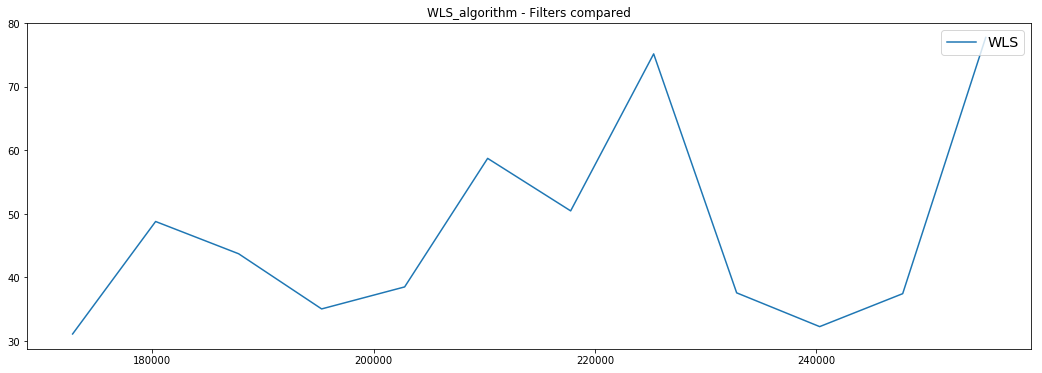

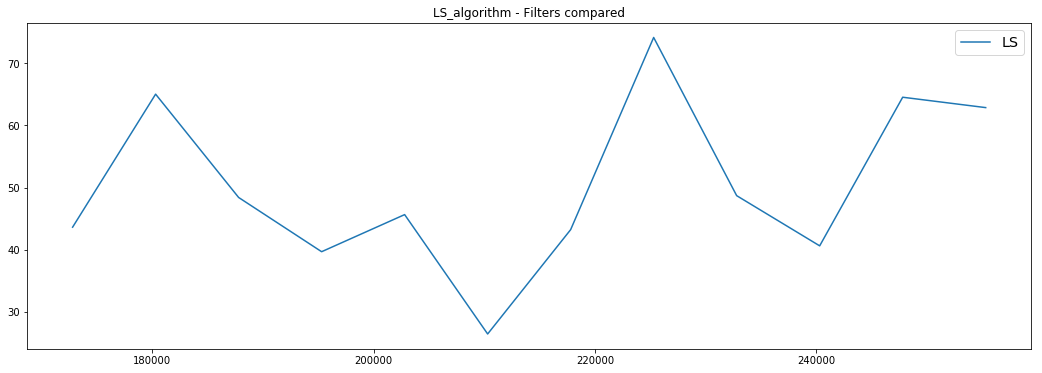

In [21]:
plots = {}
plots = plot_analysis(Resultados, station, type_analysis="filters")

Iono_models_compared for bara0100.17


Implementation  Error mean[m]  Error Std[m]
0  WLS_iono_dual_freq      45.550042     16.397746
1   LS_iono_dual_freq      56.200652     14.203373
2     WLS_iono_wallas      49.188182     18.289450
3      LS_iono_wallas      58.605707     14.905316
4    LS_iono_standard      56.492885     14.275447
5   WLS_iono_standard      45.941176     16.696476

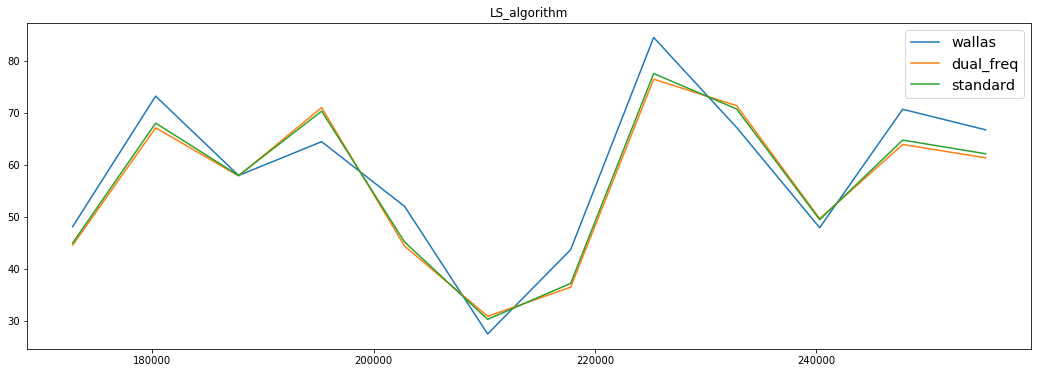

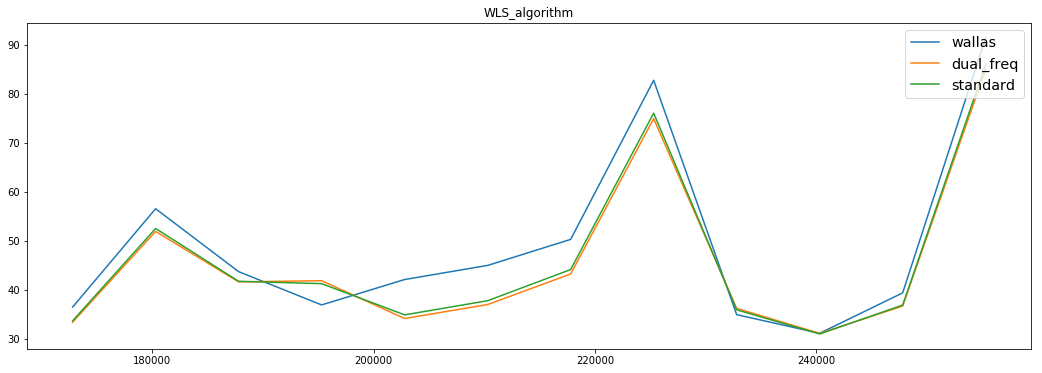

In [22]:
plots = plot_analysis(Resultados, station, type_analysis="iono_models")

In [23]:
method = "LS"
print method
points = np.array(Resultados[method]["pos"])
covars = np.array(Resultados[method]["dop"])
As = np.array(Resultados[method]["A"])
snrs = np.array(Resultados[method]["snr"]) # [o.prns_elev for i,o in data.iterrows() if i%200==0 ]
Bs = np.array(Resultados[method]["b"])
np.shape(As), np.shape(Bs), np.shape(points)

LS


((12,), (12,), (12, 4))

# test

In [24]:
# PROBANDO
def get_e(x,y):
    return np.linalg.norm(x-y, axis=0)
    
def kalman2_test(points, covars):
    X = points[0]
    A = np.eye(np.shape(X)[0])
    B = np.zeros(np.shape(A))
    U = np.ones(np.shape(X))

    P = covars[0]
    Q = np.cov(np.asarray(points).T)

    # print Q.diagonal()
    # for ind, el in enumerate(Q[:3,:3]):
    #     Q[ind, ind] = np.linalg.norm(Q.diagonal()[:3], axis=0)

    Q[3,3] = gpstk.C_MPS
    #print Q.diagonal()

    H = np.eye(np.shape(X)[0])

    def update_cov(P, X, n=0.0):
        # http://code.activestate.com/recipes/577213-incremental-pca/
        # http://www.tenpay.tech/questions/155671/incremental-pca
        # Update covariance matrix and mean vector and centralize input around
        oldmean = np.mean(X)
        mean = (n*oldmean + X) / (n + 1.0)
        P = (n*P + X*X.T + n*oldmean*oldmean.T - (n+1)*mean*mean.T) / (n + 1.0)
        #X -= mean
        return P

    def get_e(x,y):
        return np.linalg.norm(x-y, axis=0)

    ek, em = [], []
    for Y, R in zip(points[1:], covars[1:]):

        (X, P) = kf_predict(X, P, A, Q, B, U) 
        (X, P, K, IM, IS) = kf_update(X, P, Y, H, R)
        P = update_cov(P, X)
        ek.append(get_e(X[:3], rec_pos)), em.append(get_e(Y[:3], rec_pos))
        #print get_e(X[:3], rec_pos), get_e(Y[:3], rec_pos)

    print np.array(ek).mean(), np.array(em).mean()
    
kalman2_test(points, covars)

50.7397989482 50.8395693583


In [25]:
X = points[0]
P = covars[0]
ek, em = [], []
for Y, R in zip(points[1:], covars[1:]):
    X, P = kalman2(X,P,Y,R)#, points[-2:]
    ek.append(get_e(X[:3],rec_pos))
    em.append(get_e(Y[:3],rec_pos))
    #print np.array(ek).mean(), np.array(em).mean()
print np.array(ek).mean(), np.array(em).mean()

50.8152829334 50.8395693583


In [28]:
X = points[0]
P = covars[0]
ek, em = [], []
for Y, R, A, b, snr in zip(points[1:], covars[1:], As[1:], Bs[1:], snrs[1:]):
    print X, Y, np.shape(X)
    X, P = kalman3(A, X, Y, P, b, snr)#, points[-2:]
    ek.append(get_e(X[:3],rec_pos))
    em.append(get_e(Y[:3],rec_pos))
    #print np.array(ek).mean(), np.array(em).mean()
print np.array(ek).mean(), np.array(em).mean()

[ 1963358.47023327 -5733965.78411728  1980354.45784547   416679.23044631] [ 1963351.56898076 -5733932.17692173  1980346.4503537   -288950.34489167] (4,)
[ 1963362.23440896 -5733967.6367636   1980354.05868939   416681.44467178] [ 1963353.69874008 -5733969.73999059  1980346.86013453  -240126.66961616] (4,)
[ 1963361.12161393 -5733973.53104244  1980354.86902904   416684.13536157] [ 1963372.19134143 -5733988.75885233  1980375.79374789  -240112.16720429] (4,)
[ 1963359.69119947 -5733976.12649135  1980355.05545603   416686.49371914] [ 1963368.63024947 -5733942.16772478  1980347.48107311  -240145.11027034] (4,)
[ 1963360.99702525 -5733977.41842437  1980357.29781883   416688.19014729] [ 1963379.86765583 -5733964.74178744  1980341.28751555   474916.26846532] (4,)
[ 1963357.21120125 -5733966.70848761  1980356.95286598   416682.16784805] [ 1963366.39473406 -5733947.98970712  1980352.24490167  -240168.76188517] (4,)
[ 1963357.5006252  -5733967.30054376  1980355.77680137   416683.08440033] [ 196335

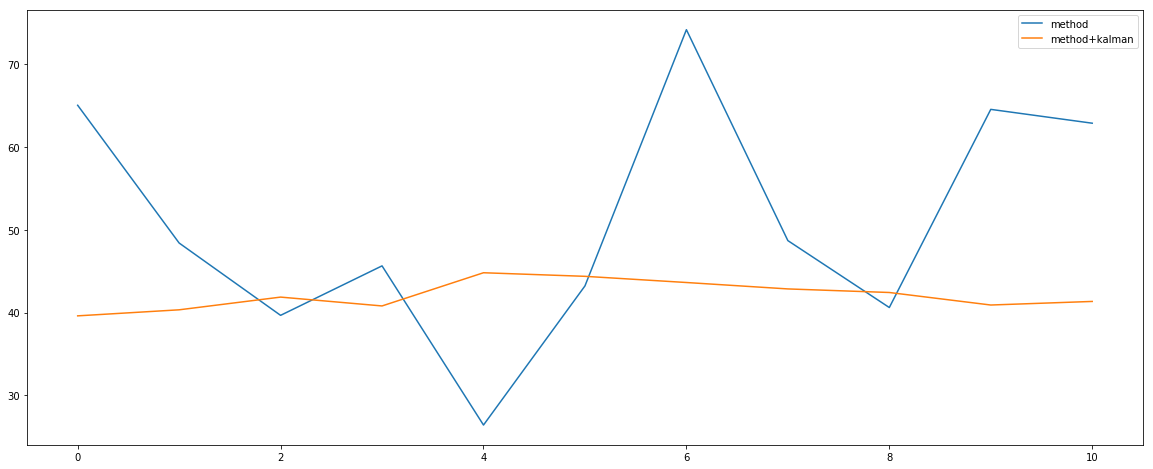

In [27]:
plt.figure(figsize=(20,8))
plt.plot(em, label="method")
plt.plot(ek, label="method+kalman")

plt.legend()
#print np.linalg.norm(xr-xp).mean(), np.linalg.norm(yr-yp).mean()

### Describing the process of position calculation

The calculation is done with only one frecuency

In [ ]:
codigo = "C1"
fase = "L1"

o = data.iloc[1300]
pranges = o[codigo]
codes = o[fase]

idxs = np.arange(len(pranges))
p1 = np.array(pranges)[idxs] 
l1 = np.array(codes)[idxs]
pos = np.array(o.prns_pos)[idxs]
clocks = np.array(o.prns_clockbias)[idxs]
clk_corr = np.array(o.gps_time_corr)
p1,pos = pranges[idxs], o.prns_pos[idxs]
clocks = o.prns_clockbias[idxs]
#raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, pranges, bcestore)
wls_computed,  A,b,_ = weight_least_squares_position(pos, p1, clocks, clk_corr, elevs=np.array(o.prns_elev), snr=np.array(o.S1))
ls_computed_pos ,  A,b,_ = compute_least_squares_position(pos, p1, clocks, clk_corr)
ls_computed_pos_CP,A,b,delta = least_squares_position_codephase(pos, p1, clocks, clk_corr, codes=codes, elevs=np.array(o.prns_elev), snr=np.array(o.S1))

#print delta, np.array(o.prns_elev)
#plt.plot(delta[:len(np.array(o.prns_elev))], np.array(o.prns_elev))

print "actual                ", rec_pos
#print "RAIM computed         ", raim_computed_pos
#print "RAIM error            ", np.linalg.norm(raim_computed_pos - rec_pos)
print "LS computed           ", ls_computed_pos
print "LS error              ", np.linalg.norm(ls_computed_pos[:3] - rec_pos)
print "WLS computed          ", wls_computed
print "WLS error             ", np.linalg.norm(wls_computed[:3] - rec_pos)
print "LS Code+Phasecomputed ", ls_computed_pos_CP[:3]
print "LS errorCP            ", np.linalg.norm(ls_computed_pos_CP[:3] - rec_pos)

## Test new kalman

In [ ]:
%run -i kalman.py
data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile, navfile)

Res = {"LS":{},
              "WLS":{}
             }

for method in Res.keys():
    Res = run_method(data, rec_pos, Res, method, apply_kalman=True)

print np.array(Res["LS"]["err"]).mean()
print np.array(Res["LS_kalman1"]["err"])#.mean() #.keys()
print np.array(Res["WLS"]["err"]).mean()
np.array(Res["WLS_kalman1"]["err"]).mean()

In [ ]:
159.84339201481112

In [ ]:
Res.keys()

In [ ]:
codigo = "C1"
fase = "L1"

method = "LS"
station = obsfile.split("/")[-1][:-1]
title = "{0} vs {1}+KalmanFilter".format(method, method)
labels= ["epoch", "positioning error [m]"]
points = np.array(Res[method]["pos"])
plot_compair_dop(points, rec_pos, station, title=title, resumen=True)

In [ ]:
method = "LS"
method += "_kalman1"
title = "{0} vs {1}+KalmanFilter".format(method, method)
labels= ["epoch", "positioning error [m]"]
points = np.array(Res[method]["pos"])
plot_compair_dop(points, rec_pos, station, title=title, resumen=True)

In [ ]:
#np.linalg.pinv(A.T.dot(A))

## Using Kalman

### First aproach

We only use (x,y,z,t) as model input

We use the matrix of delution as the error of the model

In [ ]:
%run -i kalman.py
Res_A = {"LS":{},
              "LS+CP":{},
              "WLS":{}
             }

codigo = "C1"
fase = "L1"

method = "LS"
station = obsfile.split("/")[-1][:-1]
title = "{0} vs {1}+KalmanFilter".format(method, method)
labels= ["epoch", "positioning error [m]"]

R = Analisis(data, rec_pos, Res_A, method, resolution=100, apply_kalman=True)
#plot_kalman_vs_method(R, method, station, title, labels)

points = np.array(R[method]["pos"])
plot_compair_dop(points, rec_pos, station, title=title, resumen=True)

In [ ]:
method = "WLS"
station = obsfile.split("/")[-1][:-1]
title = "{0} vs {1}+KalmanFilter".format(method, method)
labels= ["epoch", "positioning error [m]"]
R = Analisis(data, rec_pos, Res_A, method, resolution=100, apply_kalman=True)
points = np.array(R[method]["pos"])
plot_compair_dop(points, rec_pos, station, title=title, resumen=True)

### Second aproach

We add the velocity vector to the model (x, y, z, t, $v_x$, $v_y$, $v_z$)

In [ ]:
print method
points = np.array(Resultados[method]["pos"])
covars = np.array(Resultados[method]["dop"])

In [ ]:
points[0]

In [ ]:
from numpy import dot
from scipy.linalg import pinv as inv

v = np.array([0, 0, 0])
_add_zeros = lambda(P): np.hstack([np.vstack([P, np.zeros((3,4))]), np.zeros((7,3))])

x = np.append(points[0], v)
P = _add_zeros(covars[0])
Q = np.cov(np.asarray(points).T)
Q = Q / np.linalg.norm(Q)
Q = _add_zeros(Q)

H = np.eye(7,7)
F = np.array([[ 1.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  1.,  0.,  0.,  0.,  1.],
              [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]])

xs, cov = [], []
for z, R in zip(points[1:], covars[1:]):
    z = np.append(z, v)
    R = _add_zeros(R)
    
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + 9*R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

In [ ]:
error_ls = []
for p in points:
    e = np.linalg.norm(p[:3] - rec_pos)
    error_ls.append(e)

error_kl = []
for x in xs:
    e = np.linalg.norm(x[:3] - rec_pos)
    error_kl.append(e)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(error_ls[:], marker='.', color='green', linewidth=0, label="sin kalman")
plt.plot(np.roll(error_kl[:],1), marker='.', color='blue', linewidth=0, label=" con kalman")
plt.legend()

In [ ]:
plot_compair_dop(points, rec_pos, station)

In [ ]:
print "Total error =", np.mean(np.linalg.norm(points[:,:3] - rec_pos, axis=1))

### Third aproach

Remodel of the error step, we only add the error of the clock

In [ ]:
from numpy import dot
from scipy.linalg import pinv as inv

v = np.array([0, 0, 0])
_add_zeros = lambda(P): np.hstack([np.vstack([P, np.zeros((3,4))]), np.zeros((7,3))])

x = np.append(points[0], v)
P = _add_zeros(covars[0])
_Q = np.cov(np.asarray(points).T)
_Q = _Q / np.linalg.norm(_Q)
#Q = np.zeros((7,7))
Q[3,3] = 19# 3.053938    # np.std(points[3]) / 1000    # It is magic, not science

#Q = np.zeros((4,4))
#Q[3, [0,1,2,3]] = _Q[3, [0,1,2,3]]
#Q[[0,1,2,3], 3] = _Q[[0,1,2,3], 3]
#Q = _add_zeros(Q)

H = np.eye(7,7)
F = np.array([[ 1.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  1.,  0.,  0.,  0.,  1.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]])

xs, cov = [], []
for z, R in zip(points[1:], covars[1:]):
    z = np.append(z, v)
    R = _add_zeros(R)
    
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + 9*R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

In [ ]:
error_ls = []
for p in points:
    e = np.linalg.norm(p[:3] - rec_pos)
    error_ls.append(e)

error_kl = []
for x in xs:
    e = np.linalg.norm(x[:3] - rec_pos)
    error_kl.append(e)

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(error_ls[:], marker='.', color='green', linewidth=0)
plt.plot(np.roll(error_kl[:],1), marker='.', color='blue', linewidth=0)
plt.ylim((0,60))

In [ ]:
# _points = np.asarray([p for p in xs])

# enu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))
# enu_mean = enu_all.mean(axis=1)

# plt.figure(figsize=(16,8))

# plt.subplot(1, 2, 1)
# plt.scatter(enu_all[0], enu_all[1], marker='.')
# plt.scatter(enu_mean[0], enu_mean[1], marker='.', c='r')

# plt.subplot(1, 2, 2)
# plt.plot(enu_all[2])

In [ ]:
print "Total error =", np.mean(np.linalg.norm(points[:,:3] - rec_pos, axis=1))